In [4]:
import h5py
import numpy as np
filename = "/pscratch/sd/s/shas1693/data/weather/era5/latlon_025deg_hdf5/stats/stats_v1.0.h5"

with h5py.File(filename, "r") as f:
    print("Keys: %s" % f.keys())
    channels = np.array(f['channel'])
    diff_std = np.array(f['temp_diff_std'])
    global_std = np.array(f['global_std'])
channels

# filename = "/pscratch/sd/s/shas1693/data/weather/era5/latlon_025deg_hdf5/invar/invariants.h5"
# with h5py.File(filename, "r") as f:
#     print("Keys: %s" % f.keys())
#     data = np.array(f['data'])
# data.shape

Keys: <KeysViewHDF5 ['channel', 'global_mean', 'global_std', 'temp_diff_std', 'temp_diff_std_length_02']>


array([b'u10m', b'v10m', b't2m', b'tcwv', b'sp', b'msl', b'u50', b'u100',
       b'u150', b'u200', b'u250', b'u300', b'u400', b'u500', b'u600',
       b'u700', b'u850', b'u925', b'u1000', b'v50', b'v100', b'v150',
       b'v200', b'v250', b'v300', b'v400', b'v500', b'v600', b'v700',
       b'v850', b'v925', b'v1000', b'z50', b'z100', b'z150', b'z200',
       b'z250', b'z300', b'z400', b'z500', b'z600', b'z700', b'z850',
       b'z925', b'z1000', b't50', b't100', b't150', b't200', b't250',
       b't300', b't400', b't500', b't600', b't700', b't850', b't925',
       b't1000', b'q50', b'q100', b'q150', b'q200', b'q250', b'q300',
       b'q400', b'q500', b'q600', b'q700', b'q850', b'q925', b'q1000'],
      dtype='|S5')

In [1]:
# import torch.nn.functional as F
# from utilities3 import *
# from timeit import default_timer

import numpy as np
import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
import sys
import netCDF4 as nc
from load_data import *
from nn_FNO import *
from nn_step_methods import *
import matplotlib.pyplot as plt
# from swinv2_global import SwinTransformerV2Cr
from nn_ViT import SimpleViT
from utilites import *

2.3.1
2.3.1


/global/homes/c/cainslie/.conda/envs/cainslie_env/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/global/homes/c/cainslie/.conda/envs/cainslie_env/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignme

In [4]:
mystats = calculate_mean_std_large_dataset(20000, 100000, 10000)

In [5]:
import pickle
with open("dataset_stats.pkl", "wb") as file:
    # Use pickle.dump() to save the object to the file
    stats_dict = {}
    stats_dict['mean'] = mystats.mean
    stats_dict['std'] = mystats.std
    pickle.dump(stats_dict, file)

In [ ]:
lead = 1
spinup = 15000
N_test = 5000
N_train = 15000

print(spinup, N_test, N_train)
### load test data ##
psi_test_input_Tr_torch = load_train_data_v2(spinup, N_test)

m1 = torch.mean (psi_test_input_Tr_torch.flatten())
s1 = torch.std(psi_test_input_Tr_torch.flatten())

psi_test_input_Tr_torch_norm = (psi_test_input_Tr_torch[:,0,None,:,:]-m1)/s1

# psi_test_label_Tr_torch_norm = (psi_test_label_Tr_torch[:,0,None,:,:]-m1)/s1
#########

# psi_test_label_Tr = psi_test_label_Tr_torch.detach().cpu().numpy()




In [5]:
psi_test_input_Tr_torch.shape

torch.Size([5000, 1, 256, 256])

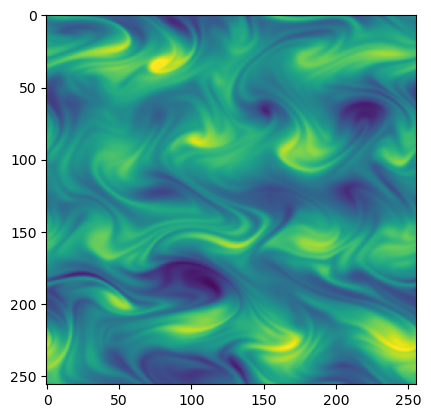

In [21]:
plt.imshow(psi_test_input_Tr_torch_norm[0,0].T, vmin=-3, vmax=3)

In [12]:
device = 'cpu'
################################################################
# configs
################################################################
path_outputs = '/global/homes/c/cainslie/LBL_J_Spectral_Stability/2d_turb_outputs_scratch'


time_step = 1e-2
# lead = int((1/1e-4)*time_step)
lead = int((1/1e-2)*time_step)

print(time_step, lead)

spinup = 20000
N_test = 50000
N_train = 100000
print(spinup + N_train, spinup + N_train + lead*N_test)

### load test data ##
# psi_test_input_Tr_torch = load_data_with_lead(N_train + spinup, N_test, lead)
psi_test_input_Tr_torch = load_train_data_v2(spinup, N_test)

m1 = torch.mean (psi_test_input_Tr_torch.flatten())
s1 = torch.std(psi_test_input_Tr_torch.flatten())

psi_test_input_Tr_torch_norm = (psi_test_input_Tr_torch[:,0,None,:,:]-m1)/s1

# psi_test_label_Tr_torch_norm = (psi_test_label_Tr_torch[::lead,0,None,:,:]-m1)/s1
#########

# psi_test_label_Tr = psi_test_label_Tr_torch.detach().cpu().numpy()

Nlat = 256
Nlon = 256

batch_size = 50 
num_epochs = 40
num_samples = 2

lamda_reg =0.0
wavenum_init=10
wavenum_init_ydir=10


# modes = 64
# width = 96



# img_size = [256, 256]
# patch_size = 16
# img_window_ratio = 32
# in_chans = 1
# out_chans = 1
# embed_dim = 320
# depths = (2, 2, 12, 4)
# num_heads = (2, 8, 16, 32)


img_size = (256, 256)
patch_size = (8, 8)
in_chans = 1
out_chans = 1
embed_dim = 1536
depth = 12
num_heads = 8
head_dim = 192
print('Data loaded')


0.01 1
120000 170000


KeyboardInterrupt: 

In [13]:
################################################################
# network declaration
################################################################
net_file_path = 'ViT_Euler_multistep_dt0.1_extra_big_epoch_20.pt'

# mynet = FNO2d(modes, modes, width)

# mynet = SwinTransformerV2Cr(img_size, patch_size, 
#                             img_window_ratio=img_window_ratio, 
#                             in_chans=in_chans, out_chans=out_chans, 
#                             embed_dim=embed_dim,
#                             depths=depths,
#                             num_heads=num_heads
#                             ).cuda()


mynet = SimpleViT(img_size, patch_size, out_chans, embed_dim ,depth=depth, heads=num_heads, mlp_dim=embed_dim*4, channels=in_chans, dim_head=head_dim).cuda()


Step_F = Euler_step(mynet, device, 1e-1).to(device)

Step_F.load_state_dict(torch.load(net_file_path, map_location=device))
print(net_file_path)

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 

In [74]:
############# Auto-regressive prediction #####################
# m1 = torch.mean (psi_test_input_Tr_torch.flatten())
# s1 = torch.std(psi_test_input_Tr_torch.flatten())
# Number of ICs you want to test
num_ICs = 5   # for example, first 5 initial conditions
psi_test_input_Tr_torch_norm_lead = psi_test_input_Tr_torch_norm[::lead]
steps_per_IC = int(psi_test_input_Tr_torch_norm_lead.shape[0]) - 1  # steps for each IC

# Allocate arrays: shape [num_ICs, steps, 1, Nlat, Nlon]
autoreg_pred = np.zeros([num_ICs, steps_per_IC, 1, Nlat, Nlon])
net_pred_truth = np.zeros([num_ICs, steps_per_IC, 1, Nlat, Nlon])
e_vec_pre_eps = np.zeros([num_ICs, steps_per_IC, 1, Nlat, Nlon])
e_vec = np.zeros([num_ICs, steps_per_IC, 1, Nlat, Nlon])
eps_sum = np.zeros([num_ICs, steps_per_IC, 1, Nlat, Nlon])

print(f"Starting evaluation for {num_ICs} initial conditions, {steps_per_IC} steps each.")

for ic in range(num_ICs):
    print(f"\n=== Initial Condition {ic+1}/{num_ICs} ===")
    
    for k in range(steps_per_IC):
        if k % 100 == 0:
            print(f"Step {k}")

        if k == 0:
            # First step: start from the given IC
            init_state = psi_test_input_Tr_torch_norm_lead[ic, :, 0:Nlat, 0:Nlon].reshape([1, 1, Nlat, Nlon]).to(device).float()

            out = Step_F(init_state)
            autoreg_pred[ic, k] = out.detach().cpu().numpy()

            net_output_truth = Step_F(init_state)
            net_pred_truth[ic, k] = net_output_truth.detach().cpu().numpy()

            eps_sum[ic, k] = net_output_truth.squeeze(-1).detach().cpu().numpy() - \
                             psi_test_input_Tr_torch_norm_lead[ic + 1].detach().cpu().numpy()

            e_vec_pre_eps[ic, 0] = 0
            e_vec[ic, 0] = eps_sum[ic, 0]

        else:
            # Autoregressive prediction from previous step
            prev_state = torch.from_numpy(autoreg_pred[ic, k-1, :, 0:Nlat, 0:Nlon].reshape([1, 1, Nlat, Nlon])).float().to(device)
            out = Step_F(prev_state)
            autoreg_pred[ic, k] = out.detach().cpu().numpy()

            # True model output with jvp
            net_output_truth, e_vec_temp = torch.func.jvp(
                Step_F,
                (psi_test_input_Tr_torch_norm_lead[ic + k, :, 0:Nlat, 0:Nlon].reshape([1, 1, Nlat, Nlon]).to(device).float(),),
                (torch.tensor(e_vec[ic, k-1, :, 0:Nlat, 0:Nlon]).to(device).float(),)
            )

            net_pred_truth[ic, k] = net_output_truth.detach().cpu().numpy()

            eps_single = net_output_truth.squeeze(-1).detach().cpu().numpy() - \
                         psi_test_input_Tr_torch_norm_lead[ic + k + 1].detach().cpu().numpy()

            eps_sum[ic, k] = eps_sum[ic, k-1] + eps_single
            e_vec_pre_eps[ic, k] = e_vec_temp.detach().cpu().numpy()
            e_vec[ic, k] = e_vec_pre_eps[ic, k] + eps_single

print("Finished all ICs.")

# Optional denormalization
# m1 = m1.detach().cpu().numpy()
# s1 = s1.detach().cpu().numpy()
# autoreg_pred_denorm = autoreg_pred * s1 + m1

Starting  1399
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Finished


In [22]:
label = psi_test_input_Tr_torch_norm

In [44]:
net_pred_multistep_dt0_001 = autoreg_pred
net_pred_truth_multistep_dt0_001 = net_pred_truth
eps_sum_multistep_dt0_001 = eps_sum
e_vec_multistep_dt0_001 = e_vec
e_vec_pre_eps_multistep_dt0_001 = e_vec_pre_eps

In [38]:
net_pred_multistep_dt0_01 = autoreg_pred
net_pred_truth_multistep_dt0_01 = net_pred_truth
eps_sum_multistep_dt0_01 = eps_sum
e_vec_multistep_dt0_01 = e_vec
e_vec_pre_eps_multistep_dt0_01 = e_vec_pre_eps

In [60]:
net_pred_multistep_dt0_1 = autoreg_pred
net_pred_truth_multistep_dt0_1 = net_pred_truth
eps_sum_multistep_dt0_1 = eps_sum
e_vec_multistep_dt0_1 = e_vec
e_vec_pre_eps_multistep_dt0_1 = e_vec_pre_eps

In [66]:
net_pred_multistep_dt0_2 = autoreg_pred
net_pred_truth_multistep_dt0_2 = net_pred_truth
eps_sum_multistep_dt0_2 = eps_sum
e_vec_multistep_dt0_2 = e_vec
e_vec_pre_eps_multistep_dt0_2 = e_vec_pre_eps

In [71]:
net_pred_multistep_dt0_3 = autoreg_pred
net_pred_truth_multistep_dt0_3 = net_pred_truth
eps_sum_multistep_dt0_3 = eps_sum
e_vec_multistep_dt0_3 = e_vec
e_vec_pre_eps_multistep_dt0_3 = e_vec_pre_eps

In [75]:
net_pred_multistep_dt0_5 = autoreg_pred
net_pred_truth_multistep_dt0_5 = net_pred_truth
eps_sum_multistep_dt0_5 = eps_sum
e_vec_multistep_dt0_5 = e_vec
e_vec_pre_eps_multistep_dt0_5 = e_vec_pre_eps

In [7]:
net_pred_multistep_lead1 = autoreg_pred
net_pred_truth_multistep_lead1 = net_pred_truth
eps_sum_multistep_lead1 = eps_sum
e_vec_multistep_lead1 = e_vec
e_vec_pre_eps_multistep_lead1 = e_vec_pre_eps

In [6]:
net_pred_multistep_lead5 = autoreg_pred
net_pred_truth_multistep_lead5 = net_pred_truth
eps_sum_multistep_lead5 = eps_sum
e_vec_multistep_lead5 = e_vec
e_vec_pre_eps_multistep_lead5 = e_vec_pre_eps

In [20]:
net_pred_multistep_lead10 = autoreg_pred
net_pred_truth_multistep_lead10 = net_pred_truth
eps_sum_multistep_lead10 = eps_sum
e_vec_multistep_lead10 = e_vec
e_vec_pre_eps_multistep_lead10 = e_vec_pre_eps

In [27]:
net_pred_multistep_full_modes = autoreg_pred
net_pred_truth_multistep_full_modes = net_pred_truth
eps_sum_multistep_full_modes = eps_sum
e_vec_multistep_full_modes = e_vec
e_vec_pre_eps_multistep_full_modes = e_vec_pre_eps

In [10]:
net_pred_singlestep_full_modes = autoreg_pred
net_pred_truth_singlestep_full_modes = net_pred_truth
eps_sum_singlestep_full_modes = eps_sum
e_vec_singlestep_full_modes = e_vec
e_vec_pre_eps_singlestep_full_modes = e_vec_pre_eps

In [29]:
net_pred_multistep_half_modes = autoreg_pred
net_pred_truth_multistep_half_modes = net_pred_truth
eps_sum_multistep_half_modes = eps_sum
e_vec_multistep_half_modes = e_vec
e_vec_pre_eps_multistep_half_modes = e_vec_pre_eps

In [25]:
net_pred_singlestep_half_modes = autoreg_pred
net_pred_truth_singlestep_half_modes = net_pred_truth
eps_sum_singlestep_half_modes = eps_sum
e_vec_singlestep_half_modes = e_vec
e_vec_pre_eps_singlestep_half_modes = e_vec_pre_eps

/tmp/ipykernel_593020/3715288346.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label_normed = (psi_test_input_Tr_torch[::,0,None,:,:]-m1)/s1


0.1
0.2
0.3
0.5


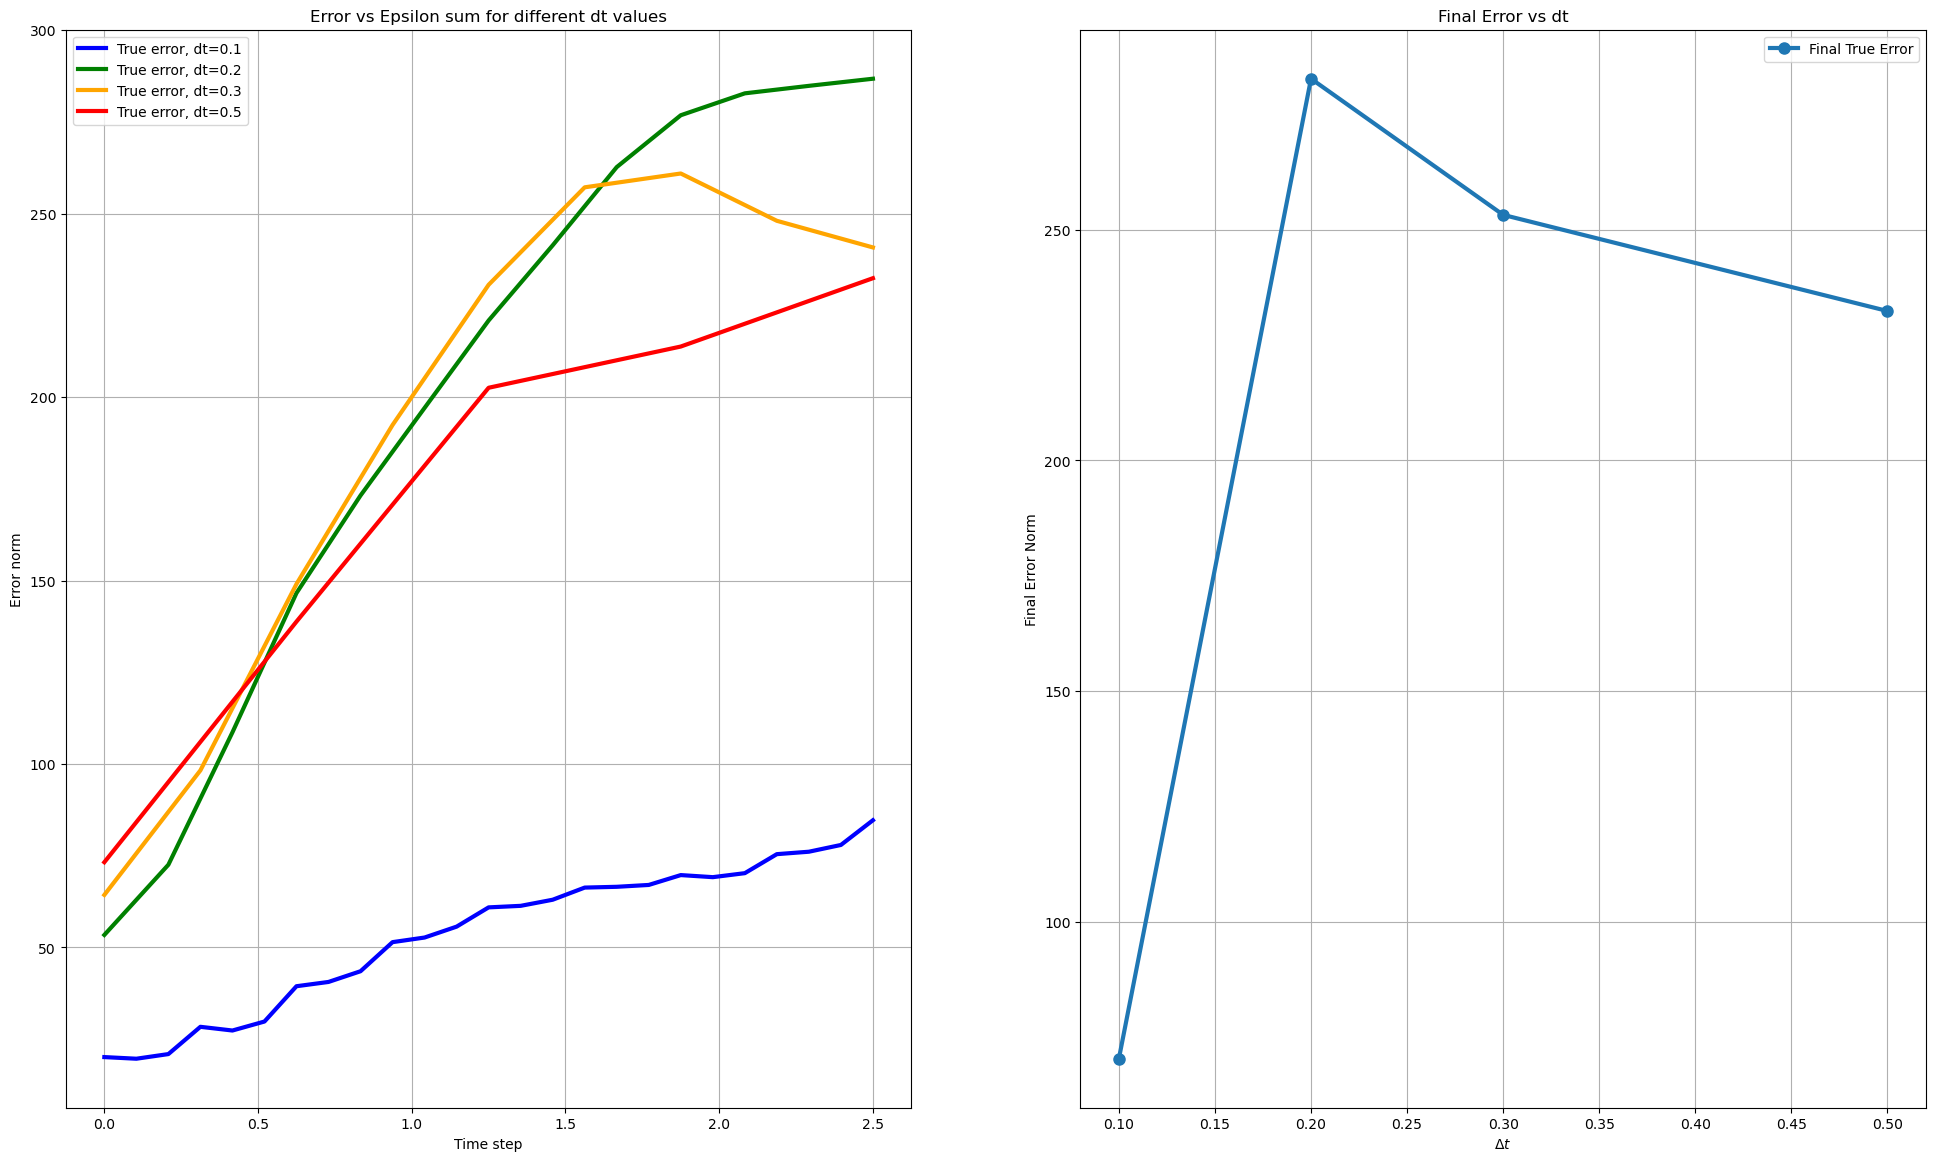

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(24, 14))
trange = 25
t_final = trange * 1e-1

# Define dt values and corresponding variable mappings
dt_values = [0.1, 0.2, 0.3, 0.5]

pred_vars = {
    0.1: net_pred_multistep_dt0_1,
    0.2: net_pred_multistep_dt0_2,
    0.3: net_pred_multistep_dt0_3,
    0.5: net_pred_multistep_dt0_5
}

eps_vars = {
    0.1: eps_sum_multistep_dt0_1,
    0.2: eps_sum_multistep_dt0_2,
    0.3: eps_sum_multistep_dt0_3,
    0.5: eps_sum_multistep_dt0_5
}

colors = {
    0.1: 'blue',
    0.2: 'green',
    0.3: 'orange',
    0.5: 'red'
}
label_normed = (psi_test_input_Tr_torch[::,0,None,:,:]-m1)/s1

# First subplot: Error curves over time
for dt in dt_values:
    print(dt)
    lead = int((1/1e-1)*dt) 
    res_norm = np.linalg.norm(
        (pred_vars[dt][0:trange:lead] - label_normed[1:trange+1:lead].detach().cpu().numpy()),
        axis=(2, 3)
    )
    # eps_norm = np.linalg.norm(eps_vars[dt][0:trange], axis=(2, 3))

    axs[0].plot(np.linspace(0, t_final, res_norm.shape[0]), res_norm, color=colors[dt], label=f'True error, dt={dt}', linewidth=3)
    # axs[0].plot(np.linspace(0, t_final, eps_norm.shape[0]), eps_norm, ':', color=colors[dt], label=f'Epsilon sum, dt={dt}', linewidth=2)

axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Error norm')
axs[0].set_title('Error vs Epsilon sum for different dt values')
axs[0].legend()
axs[0].grid(True)

# Second subplot: Final error vs dt
final_errors = []
final_eps = []
for dt in dt_values:
    res_norm = np.linalg.norm(
        (pred_vars[dt][0:trange:lead] - label_normed[1:trange+1:lead].detach().cpu().numpy()),
        axis=(2, 3)
    )
    # eps_norm = np.linalg.norm(eps_vars[dt][0:trange], axis=(2, 3))
    final_errors.append(res_norm[-1])
    # final_eps.append(eps_norm[-1])

axs[1].plot(dt_values, final_errors, 'o-', label='Final True Error', linewidth=3, markersize=8)
# axs[1].plot(dt_values, final_eps, 's--', label='Final Epsilon Sum', linewidth=3, markersize=8)
axs[1].set_xlabel(r'$\Delta t$')
axs[1].set_ylabel('Final Error Norm')
axs[1].set_title('Final Error vs dt')
axs[1].legend()
axs[1].grid(True)

plt.show()

Text(0.5, 1.0, '$d(t) = e(t) - \\sum_{i=0}^t\\left[\\epsilon(u(i))\\right]$')

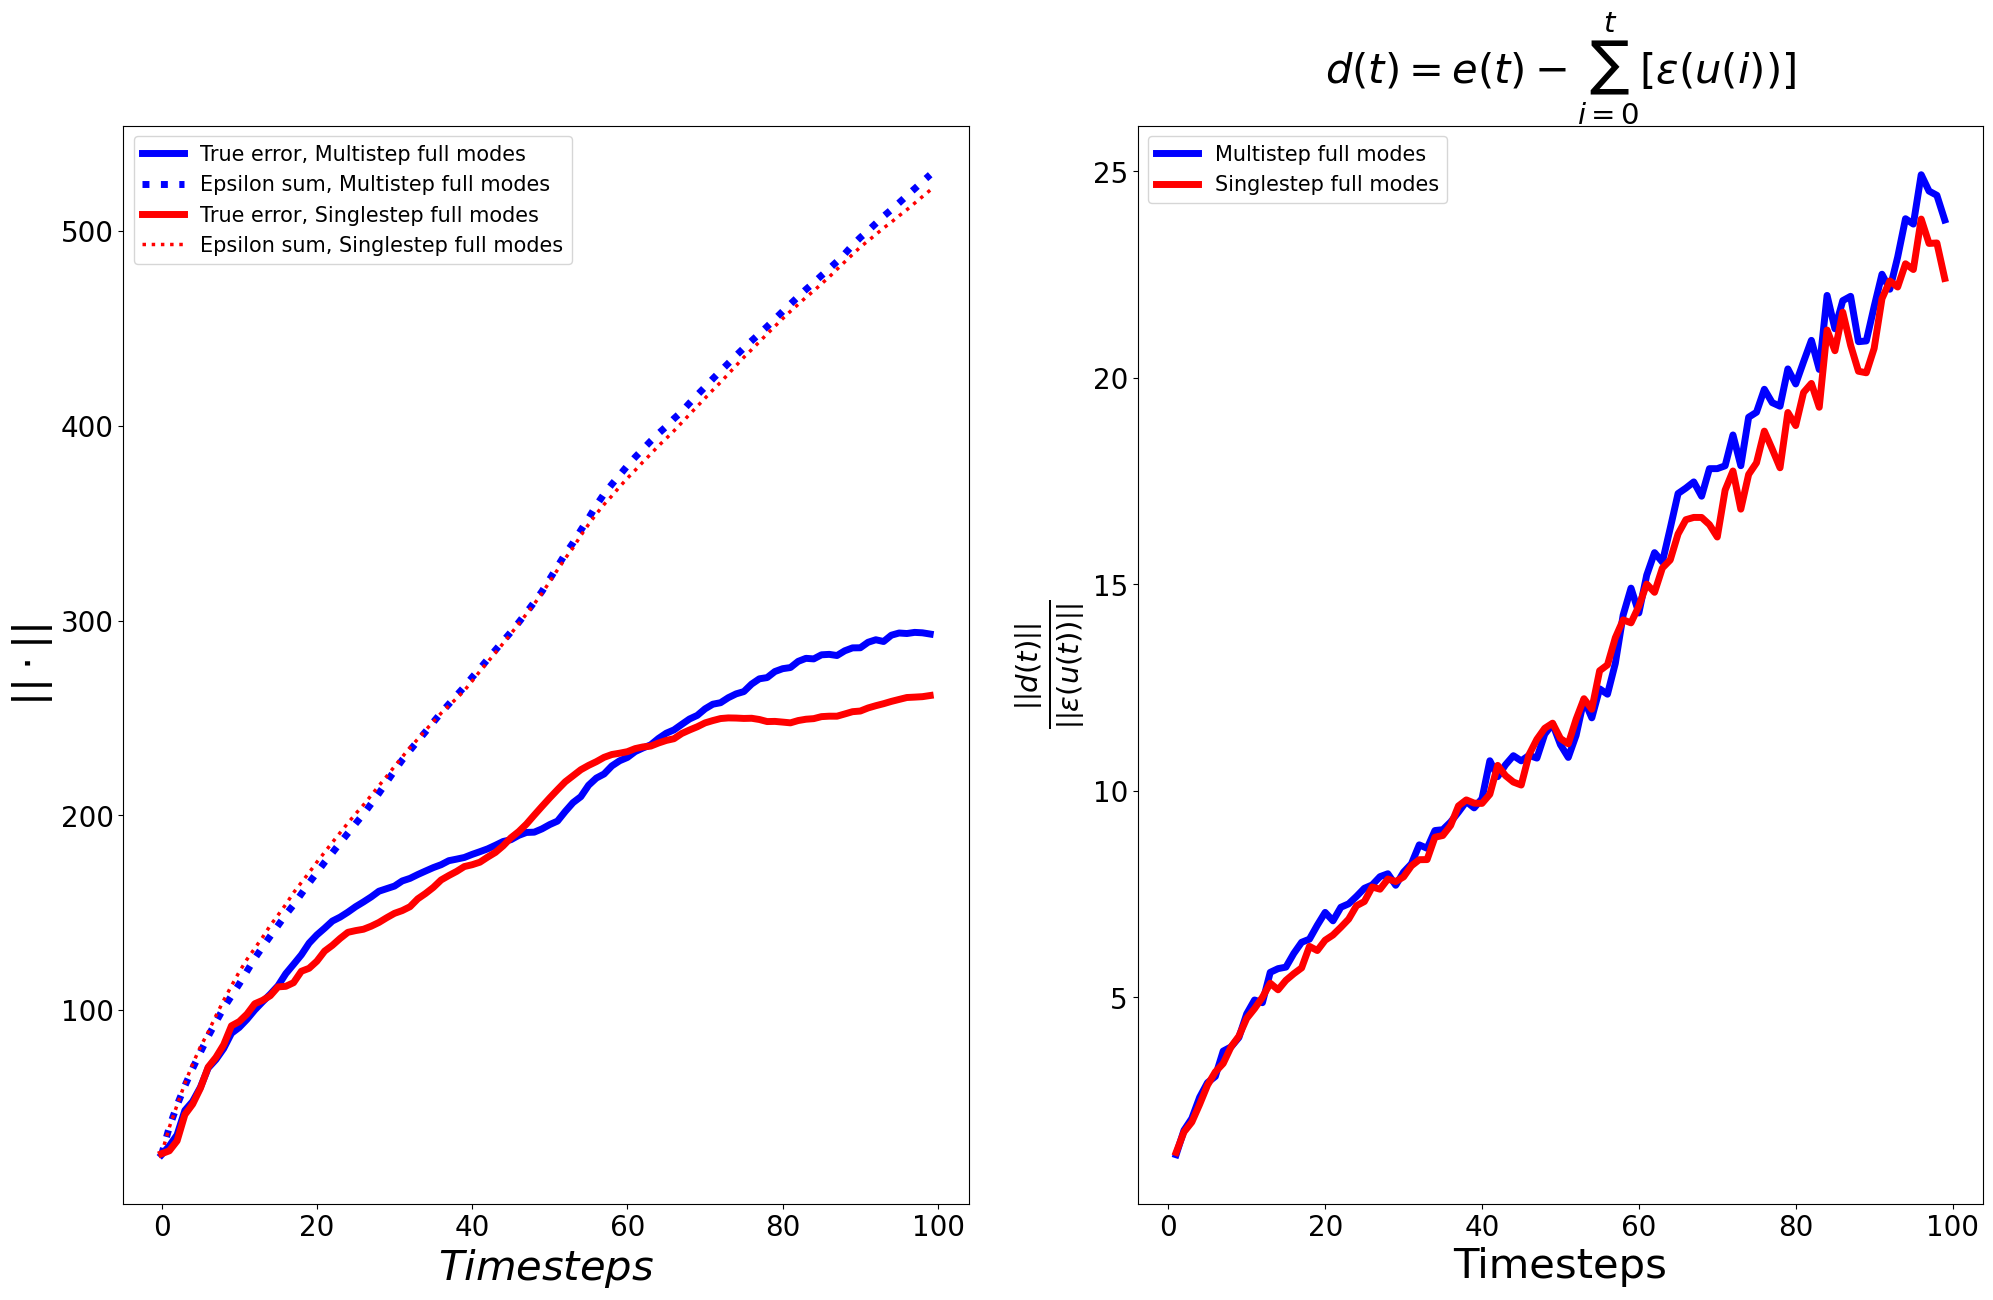

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(24, 14))
trange = 100


res_norm = np.linalg.norm((net_pred_multistep_full_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy()), axis=(2,3)) 
eps_norm = np.linalg.norm(eps_sum_multistep_full_modes[0:trange], axis=(2,3)) 

axs[0].plot(res_norm, color='blue', label='True error, Multistep full modes', linewidth=5)
axs[0].plot(eps_norm,':', color='blue', label='Epsilon sum, Multistep full modes', linewidth=5)


res_norm_2 = np.linalg.norm((net_pred_singlestep_full_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy()), axis=(2,3))
eps_norm_2 = np.linalg.norm(eps_sum_singlestep_full_modes[0:trange], axis=(2,3))
axs[0].plot(res_norm_2, color='red', label='True error, Singlestep full modes', linewidth=5)
axs[0].plot(eps_norm_2,':', color='red', label='Epsilon sum, Singlestep full modes', linewidth=2.5)


# res_norm = np.linalg.norm((net_pred_multistep_half_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy()), axis=(2,3)) 
# eps_norm = np.linalg.norm(eps_sum_multistep_half_modes[0:trange], axis=(2,3)) 

# res_norm_2 = np.linalg.norm((net_pred_singlestep_half_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy()), axis=(2,3))
# eps_norm_2 = np.linalg.norm(eps_sum_singlestep_half_modes[0:trange], axis=(2,3))

# axs[0].plot(res_norm, color='blue', label='True error, Multistep half modes', linewidth=5)
# axs[0].plot(eps_norm,':', color='blue', label='Epsilon sum, Multistep half modes', linewidth=5)
# axs[0].plot(res_norm_2, color='red', label='True error, Singlestep half modes', linewidth=5)
# axs[0].plot(eps_norm_2,':', color='red', label='Epsilon sum, Singlestep half modes', linewidth=5)




# axs[0].plot(np.sqrt(np.mean((net_pred_multistep_full_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy())**2, axis=(2,3))), color='blue', label='True error, Multistep full modes')
# axs[0].plot(np.sqrt(np.mean(eps_sum_multistep_full_modes[0:trange]**2, axis=(2,3))),':', color='blue', label='Epsilon sum,  Multistep full modes')
# axs[0].plot(np.sqrt(np.mean((net_pred_singlestep_full_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy())**2, axis=(2,3))), color='red', label='True error, Singlestep full modes')
# axs[0].plot(np.sqrt(np.mean(eps_sum_singlestep_full_modes[0:trange]**2, axis=(2,3))),':', color='red', label='Epsilon sum,  Singlestep full modes')



# axs[0].plot(np.sqrt(np.mean((net_pred_multistep_half_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy())**2, axis=(2,3))), color='blue', label='True error, Multistep half modes')
# axs[0].plot(np.sqrt(np.mean(eps_sum_multistep_half_modes[0:trange]**2, axis=(2,3))),':', color='blue', label='Epsilon sum,  Multistep half modes')
# axs[0].plot(np.sqrt(np.mean((net_pred_singlestep_half_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy())**2, axis=(2,3))), color='red', label='True error, Singlestep half modes')
# axs[0].plot(np.sqrt(np.mean(eps_sum_singlestep_half_modes[0:trange]**2, axis=(2,3))),':', color='red', label='Epsilon sum,  Singlestep half modes')





axs[0].set_xlabel(r'$Timesteps$', fontsize=30)
axs[0].set_ylabel(r'$||\cdot ||$', fontsize=30)
axs[0].legend(loc='upper left', prop={'size':15})
axs[0].xaxis.set_tick_params(labelsize=20)
axs[0].yaxis.set_tick_params(labelsize=20)
# axs[0].set_xlim(0, 5)




e_vec = (net_pred_multistep_full_modes[0:trange] - label[ 1:trange+1].detach().cpu().numpy())
eps_sum = eps_sum_multistep_full_modes[0:trange]

e_vec_2 = (net_pred_singlestep_full_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy())
eps_sum_2 =  eps_sum_singlestep_full_modes[0:trange]


# e_vec = (net_pred_multistep_half_modes[0:trange] - label[ 1:trange+1].detach().cpu().numpy())
# eps_sum = eps_sum_multistep_half_modes[0:trange]

# e_vec_2 = (net_pred_singlestep_half_modes[ 0:trange] - label[ 1:trange+1].detach().cpu().numpy())
# eps_sum_2 =  eps_sum_singlestep_half_modes[0:trange]


diff_vec_norm = np.linalg.norm(e_vec - eps_sum, axis=(2,3))
eps_norm = np.linalg.norm(eps_sum[1:] - eps_sum[:-1], axis=(2,3))

diff_vec_norm_2 = np.linalg.norm(e_vec_2 - eps_sum_2, axis=(2,3))
eps_norm_2 = np.linalg.norm(eps_sum_2[1:] - eps_sum_2[:-1], axis=(2,3))


tstart = 0
tfinal = diff_vec_norm.shape[0]
# tfinal = trange


axs[1].plot(np.arange(tstart+1, tfinal), (diff_vec_norm[ tstart+1:tfinal])/eps_norm, color='blue', label='Multistep full modes', linewidth=5)
axs[1].plot(np.arange(tstart+1, tfinal), (diff_vec_norm_2[ tstart+1:tfinal])/eps_norm_2, color='red', label='Singlestep full modes', linewidth=5)


# axs[1].plot(np.arange(tstart+1, tfinal), (diff_vec_norm[ tstart+1:tfinal])/eps_norm, color='blue', label='Multistep half modes', linewidth=5)
# axs[1].plot(np.arange(tstart+1, tfinal), (diff_vec_norm_2[ tstart+1:tfinal])/eps_norm_2, color='red', label='Singlestep half modes', linewidth=5)


axs[1].legend(loc='upper left', prop={'size':15})
axs[1].xaxis.set_tick_params(labelsize=20)
axs[1].yaxis.set_tick_params(labelsize=20)
axs[1].set_xlabel('Timesteps', fontsize=30)
axs[1].set_ylabel(r'$\frac{  \left|\left|d(t)\right|\right| }{ \left|\left|\epsilon(u(t))\right|\right|} $', fontsize=30)
axs[1].set_title(r'$d(t) = e(t) - \sum_{i=0}^t\left[\epsilon(u(i))\right]$', fontsize=30)


# fig.savefig('Turbulence_64_modes_v2.png', dpi=300, bbox_inches='tight')

In [123]:
net_pred_lead1 = autoreg_pred
net_pred_truth_lead1 = net_pred_truth
eps_sum_lead1 = eps_sum
e_vec_lead1 = e_vec
e_vec_pre_eps_lead1 = e_vec_pre_eps

In [45]:
label_lead1 = label

In [108]:
net_pred_lead5 = autoreg_pred
net_pred_truth_lead5 = net_pred_truth
eps_sum_lead5 = eps_sum
e_vec_lead5 = e_vec
e_vec_pre_eps_lead5 = e_vec_pre_eps

In [75]:
label_lead5 = label

In [104]:
net_pred_lead10 = autoreg_pred
net_pred_truth_lead10 = net_pred_truth
eps_sum_lead10 = eps_sum
e_vec_lead10 = e_vec
e_vec_pre_eps_lead10 = e_vec_pre_eps

In [51]:
label_lead10 = label

In [131]:
np.arange(0, t_final, )

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [ ]:
# trange_lead1 = int(2000/1) - 1
# res_norm = np.linalg.norm((net_pred_multistep_lead1[ 0:trange_lead1] - label_lead1[ 1:trange_lead1+1].detach().cpu().numpy()), axis=(2,3)) 
# eps_norm = np.linalg.norm(eps_sum_multistep_lead1[0:trange_lead1], axis=(2,3)) 

trange_lead5 = int(2000/5) - 1
res_norm_2 = np.linalg.norm((net_pred_multistep_lead5[ 0:trange_lead5] - label_lead5[ 1:trange_lead5+1].detach().cpu().numpy()), axis=(2,3))
eps_norm_2 = np.linalg.norm(eps_sum_multistep_lead5[0:trange_lead5], axis=(2,3))

# trange_lead10 = int(2000/10) - 1
# res_norm_3 = np.linalg.norm((net_pred_multistep_lead10[ 0:trange_lead10] - label_lead10[ 1:trange_lead10+1].detach().cpu().numpy()), axis=(2,3))
# eps_norm_3 = np.linalg.norm(eps_sum_multistep_lead10[0:trange_lead10], axis=(2,3))

t_final = 1e-1 * 2000

# plt.plot(np.linspace(0,t_final, trange_lead1), res_norm, color='blue', label='True error, dt=0.1', linewidth=2.5)
# plt.plot(np.linspace(0,t_final, trange_lead1), eps_norm,':', color='blue', label='Epsilon sum,  dt=0.1', linewidth=2.5)

plt.plot(np.linspace(0,t_final, trange_lead5), res_norm_2, color='red', label='True error, dt=0.5', linewidth=2.5)
plt.plot(np.linspace(0,t_final, trange_lead5), eps_norm_2,':', color='red', label='Epsilon sum, dt=0.5', linewidth=2.5)

# plt.plot(np.linspace(0,t_final, trange_lead10), res_norm_3, color='black', label='True error, dt=1', linewidth=2.5)
# plt.plot(np.linspace(0,t_final, trange_lead10), eps_norm_3,':', color='black', label='Epsilon sum, dt=1', linewidth=2.5)
plt.xlim(-0.1, 50)
plt.ylim(0, 600)

plt.legend(prop={'size':10})
plt.xlabel('Seconds', fontsize=20)
plt.ylabel(r'$||\cdot ||$', fontsize=20)
# plt.savefig('Multistep_many_dts_swin.png')

In [181]:
eps_exp = np.diff(eps_sum, axis=0)
eps_exp.mean(0).shape

(1, 256, 256)

In [ ]:
import matplotlib.animation as animation
x = np.linspace(0, 1, 256)
y = np.linspace(0, 1, 256)
X, Y = np.meshgrid(x, y)

skip = 10

# 2. Create initial plot
fig, ax = plt.subplots()
initial_Z = autoreg_pred[0,0].T
contour_plot = ax.contourf(X, Y, initial_Z, levels=20, cmap='viridis', vmin=v_min, vmax = v_max)

# 3. Define the animation function
def animate(i):
    # Clear previous contours
    # contour_plot.remove()

    # Update data for the current frame
    Z_new = autoreg_pred[i*skip,0].T

    # Plot new contours
    new_contour_plot = ax.contourf(X, Y, Z_new, levels=20, cmap='viridis', vmin=v_min, vmax = v_max)

    # Return the updated artists
    return new_contour_plot

# 4. Create the FuncAnimation object
ani = animation.FuncAnimation(fig, animate, frames=200, interval=100, blit=False) # blit=False often works better for contourf

# 5. Display or save
plt.show()
# ani.save('temp_animation.gif', writer="imagemagick")

In [12]:
psi_test_input_Tr_torch_norm.shape

torch.Size([200, 1, 256, 256])

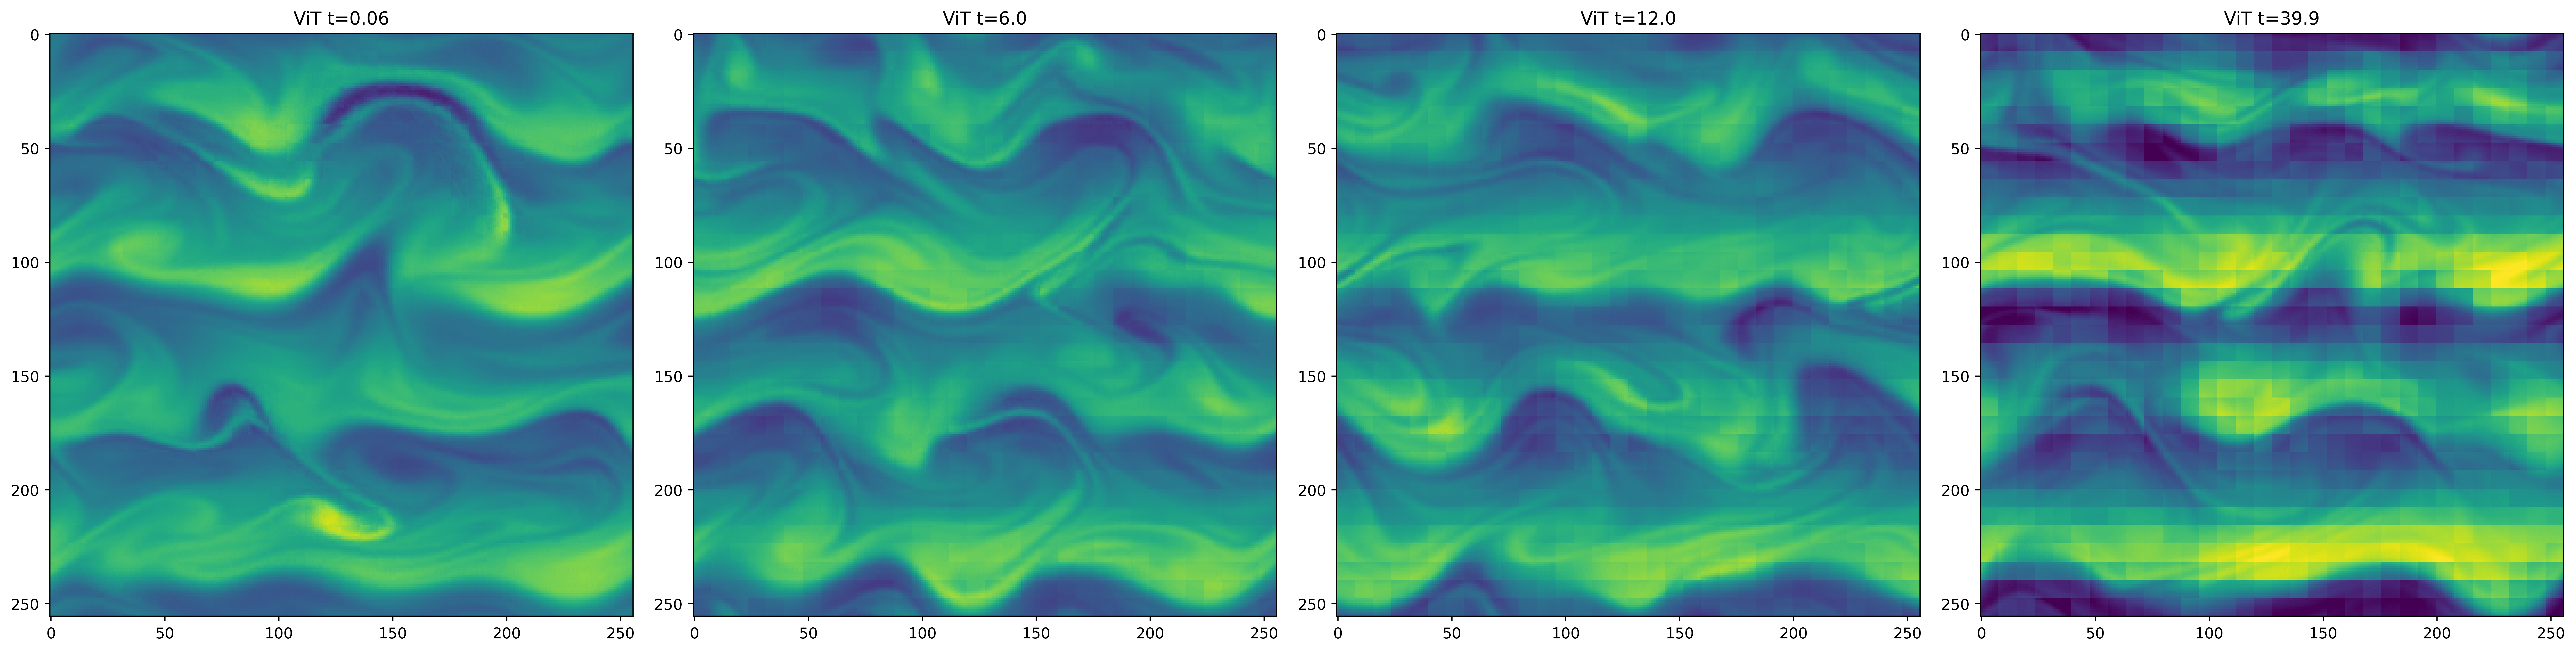

In [65]:
times = [1, 100, 200 , 665]
v_min, v_max = psi_test_input_Tr_torch_norm[:,0].min(), psi_test_input_Tr_torch_norm[:,0].max()
plt.figure(figsize=(24,16), dpi=500)
for i in range(len(times)):
    # plt.subplot(2,len(times),i+1)
    # plt.imshow(autoreg_pred[times[i],0].T, vmin=v_min, vmax = v_max)
    # plt.title(f'Predicted t= {times[i]}')
    plt.subplot(2,len(times),i+len(times)+1)
    plt.imshow(net_pred_multistep_dt0_06[0, times[i]].T, vmin=v_min, vmax = v_max)
    plt.title(f'ViT t={0.06*times[i]}')
plt.tight_layout()

In [93]:
truth_states_dt0_25.shape

torch.Size([1, 400, 1, 256, 256])

In [20]:
net_pred_multistep_dt0_1_big.shape

(50, 100, 1, 256, 256)

In [22]:
times = [1, 50, 99]
v_min, v_max = psi_test_input_Tr_torch_norm[:,0].min(), psi_test_input_Tr_torch_norm[:,0].max()
plt.figure(figsize=(24,16), dpi=500)
for i in range(len(times)):
    plt.subplot(2,len(times),i+1)
    plt.imshow(net_pred_multistep_dt0_1_big[0,times[i]].T, vmin=v_min, vmax = v_max)
    plt.title(f'Predicted t= {0.1*times[i]}')
    plt.subplot(2,len(times),i+len(times)+1)
    plt.imshow(truth_states_dt0_1_big[0, times[i]].T, vmin=v_min, vmax = v_max)
    plt.title(f'True t= {0.1*times[i]}')
plt.tight_layout()

In [2]:
device = 'cuda'
################################################################
# configs
################################################################
path_outputs = '/global/homes/c/cainslie/LBL_J_Spectral_Stability/2d_turb_outputs_scratch'


time_step = 1e-1
lead = int((1/1e-2)*time_step)
# lead = int((1/1e-1)*time_step)

print(time_step, lead)

spinup = 100
N_test = int(5000)
N_train = 100
print(spinup + N_train, spinup + N_train + lead*N_test)

### load test data ##
psi_test_input_Tr_torch = load_data_with_lead(N_train + spinup, N_test, 1)
# psi_test_input_Tr_torch, _ = load_train_data(N_train + spinup, N_test)

m1 = torch.mean (psi_test_input_Tr_torch.flatten())
s1 = torch.std(psi_test_input_Tr_torch.flatten())

psi_test_input_Tr_torch_norm = (psi_test_input_Tr_torch[:,0,None,:,:]-m1)/s1

# psi_test_label_Tr_torch_norm = (psi_test_label_Tr_torch[::lead,0,None,:,:]-m1)/s1
#########


# psi_test_label_Tr = psi_test_label_Tr_torch.detach().cpu().numpy()

Nlat = 256
Nlon = 256

batch_size = 50 
num_epochs = 40
num_samples = 2

lamda_reg =0.0
wavenum_init=10
wavenum_init_ydir=10



# modes = 64
# width = 96



# img_size = [256, 256]
# patch_size = 16
# img_window_ratio = 32
# in_chans = 1
# out_chans = 1
# embed_dim = 320
# depths = (2, 2, 12, 4)
# num_heads = (2, 8, 16, 32)


# print('Data loaded')
# print(psi_test_input_Tr_torch_norm.shape)
# num_ICs = 10                  # number of initial conditions
# total_time_steps = 1000        # horizon in steps for lead=1


# # Dynamically adjust steps_per_IC
# steps_per_IC = total_time_steps // lead
# print(f"Lead={lead}, steps_per_IC={steps_per_IC} (total horizon={total_time_steps} steps)")

# # Random starting indices (avoid going out of bounds)
# max_start = psi_test_input_Tr_torch_norm.shape[0] - steps_per_IC * lead - 1
# start_indices = np.random.choice(max_start, size=num_ICs, replace=False)
# print(f"Random starting indices: {start_indices}")

0.1 10
200 50200


In [2]:
lead = 1
spinup = 20000
N_test = 50000
N_train = 100000

print(spinup, N_test, N_train)
### load test data ##
psi_test_input_Tr_torch, psi_test_label_Tr_torch = load_test_data_v2(spinup, N_test, lead)

m1 = torch.mean (psi_test_input_Tr_torch.flatten())
s1 = torch.std(psi_test_input_Tr_torch.flatten())

psi_test_input_Tr_torch_norm = (psi_test_input_Tr_torch[:,0,None,:,:]-m1)/s1

# psi_test_label_Tr_torch_norm = (psi_test_label_Tr_torch[:,0,None,:,:]-m1)/s1
#########

# psi_test_label_Tr = psi_test_label_Tr_torch.detach().cpu().numpy()

20000 50000 100000


In [31]:
################################################################
# network declaration
################################################################
device ='cpu'
img_size = (256, 256)
patch_size = (8, 8)
in_chans = 1
out_chans = 1
embed_dim = 1536
depth = 12
num_heads = 8
head_dim = 192

Nlat = 256
Nlon = 256

net_file_path = '/global/homes/c/cainslie/LBNL_dt_scaling/model_chkpts_scratch/FNO_Euler_multistep_dt0.6_small/chkpt_FNO_Euler_multistep_dt0.6_small_epoch_10.pt'


modes = 64
width = 184

mynet = FNO2d(modes, modes, width)

# mynet = SimpleViT(img_size, patch_size, out_chans, embed_dim ,depth=depth, heads=num_heads, mlp_dim=embed_dim*4, channels=in_chans, dim_head=head_dim).to(device)

time_step = 6e-1
lead = int((1/1e-2)*time_step)

Step_F = Euler_step(mynet, device, time_step).to(device)

Step_F.load_state_dict(torch.load(net_file_path, map_location=device)['model_state_dict'])
print(net_file_path)

/global/homes/c/cainslie/LBNL_dt_scaling/model_chkpts_scratch/FNO_Euler_multistep_dt0.6_small/chkpt_FNO_Euler_multistep_dt0.6_small_epoch_10.pt


In [32]:
torch.cuda.empty_cache()

In [36]:
with torch.no_grad():    
    Step_F.eval()
    # Parameters
    num_ICs = 1
    total_time_steps = 1000
    
    # Dynamically adjust steps_per_IC
    steps_per_IC = total_time_steps // lead
    print(f"Lead={lead}, steps_per_IC={steps_per_IC} (total horizon={total_time_steps} steps)")
    
    # Random starting indices (avoid going out of bounds)
    max_start = psi_test_input_Tr_torch_norm.shape[0] - steps_per_IC * lead - 1
    # print(max_start)
    start_indices = np.random.choice(max_start, size=num_ICs, replace=False)
    # print(f"Random starting indices: {start_indices}")
    
    # Allocate arrays: shape [num_ICs, steps_per_IC, 1, Nlat, Nlon]
    autoreg_pred = np.zeros((num_ICs, steps_per_IC, 1, Nlat, Nlon))
    net_pred_truth = np.zeros((num_ICs, steps_per_IC, 1, Nlat, Nlon))
    truth_states = torch.zeros((num_ICs, steps_per_IC, 1, Nlat, Nlon))
    eps_sum = np.zeros((num_ICs, steps_per_IC, 1, Nlat, Nlon))
    
    # Initial states for all ICs
    init_states = torch.stack([
        psi_test_input_Tr_torch_norm[idx, 0:1, 0:Nlat, 0:Nlon]
        for idx in start_indices
    ], dim=0).float()
    
    # Save first truth state (lead steps ahead)
    truth_states[:, 0] = torch.stack([
        psi_test_input_Tr_torch_norm[idx + lead, :, 0:Nlat, 0:Nlon]
        for idx in start_indices
    ], dim=0).float()
    
    # First autoregressive prediction
    out = Step_F(init_states.to(device))
    autoreg_pred[:, 0] = out.detach().cpu().numpy()
    
    # First truth prediction (lead steps ahead)
    net_output_truth = Step_F(init_states.to(device))
    net_pred_truth[:, 0] = net_output_truth.detach().cpu().numpy()
    
    # First epsilon sum
    eps_sum[:, 0] = (net_output_truth.detach().cpu().numpy() -
                     truth_states[:, 0].detach().cpu().numpy())
    
    # Rollout without JVP
    print('Starting')
    for k in range(1, steps_per_IC):
        if k % 1 == 0:
            print(f"Step {k}/{steps_per_IC}")
    
        # Autoregressive prediction: feed previous forecast into network
        prev_state = torch.from_numpy(autoreg_pred[:, k-1, :, 0:Nlat, 0:Nlon]).float().to(device)
        out = Step_F(prev_state)
        autoreg_pred[:, k] = out.detach().cpu().numpy()
    
        # Truth trajectory: feed actual truth state into network
        true_input = torch.stack([
            psi_test_input_Tr_torch_norm[start_indices[i] + k*lead, :, 0:Nlat, 0:Nlon]
            for i in range(num_ICs)
        ], dim=0).to(device).float()
    
        net_output_truth = Step_F(true_input)
        net_pred_truth[:, k] = net_output_truth.detach().cpu().numpy()
    
        # Save actual truth (lead steps ahead)
        truth_states[:, k] = torch.stack([
            psi_test_input_Tr_torch_norm[start_indices[i] + k*lead + lead, :, 0:Nlat, 0:Nlon]
            for i in range(num_ICs)
        ], dim=0).to(device).float()
    
        # Epsilon update
        eps_single = (net_output_truth.detach().cpu().numpy() -
                      truth_states[:, k].detach().cpu().numpy())
        eps_sum[:, k] = eps_sum[:, k-1] + eps_single
    
    print(f"Finished all ICs with lead={lead}, final time horizon={total_time_steps} steps.")

Lead=60, steps_per_IC=16 (total horizon=1000 steps)
Starting
Step 1/16
Step 2/16
Step 3/16
Step 4/16
Step 5/16
Step 6/16
Step 7/16
Step 8/16
Step 9/16
Step 10/16
Step 11/16
Step 12/16
Step 13/16
Step 14/16
Step 15/16
Finished all ICs with lead=60, final time horizon=1000 steps.


In [129]:
net_pred_multistep_dt0_01 = autoreg_pred
net_pred_truth_multistep_dt0_01 = net_pred_truth
eps_sum_multistep_dt0_01 = eps_sum
# e_vec_multistep_dt0_01 = e_vec
# e_vec_pre_eps_multistep_dt0_01 = e_vec_pre_eps
truth_states_dt0_01 = truth_states

In [33]:
net_pred_multistep_dt0_03 = autoreg_pred
net_pred_truth_multistep_dt0_03 = net_pred_truth
eps_sum_multistep_dt0_03 = eps_sum
# e_vec_multistep_dt0_03 = e_vec
# e_vec_pre_eps_multistep_dt0_03 = e_vec_pre_eps
truth_states_dt0_03 = truth_states

In [46]:
net_pred_multistep_dt0_04 = autoreg_pred
net_pred_truth_multistep_dt0_04 = net_pred_truth
eps_sum_multistep_dt0_04 = eps_sum
# e_vec_multistep_dt0_04 = e_vec
# e_vec_pre_eps_multistep_dt0_04 = e_vec_pre_eps
truth_states_dt0_04 = truth_states

In [74]:
net_pred_multistep_dt0_05 = autoreg_pred
net_pred_truth_multistep_dt0_05 = net_pred_truth
eps_sum_multistep_dt0_05 = eps_sum
# e_vec_multistep_dt0_05 = e_vec
# e_vec_pre_eps_multistep_dt0_05 = e_vec_pre_eps
truth_states_dt0_05 = truth_states

In [12]:
net_pred_multistep_dt0_06 = autoreg_pred
net_pred_truth_multistep_dt0_06 = net_pred_truth
eps_sum_multistep_dt0_06 = eps_sum
# e_vec_multistep_dt0_06 = e_vec
# e_vec_pre_eps_multistep_dt0_06 = e_vec_pre_eps
truth_states_dt0_06 = truth_states

In [62]:
net_pred_multistep_dt0_08 = autoreg_pred
net_pred_truth_multistep_dt0_08 = net_pred_truth
eps_sum_multistep_dt0_08 = eps_sum
# e_vec_multistep_dt0_08 = e_vec
# e_vec_pre_eps_multistep_dt0_08 = e_vec_pre_eps
truth_states_dt0_08 = truth_states

In [138]:
net_pred_multistep_dt0_15 = autoreg_pred
net_pred_truth_multistep_dt0_15 = net_pred_truth
eps_sum_multistep_dt0_15 = eps_sum
# e_vec_multistep_dt0_15 = e_vec
# e_vec_pre_eps_multistep_dt0_15 = e_vec_pre_eps
truth_states_dt0_15 = truth_states

In [9]:
net_pred_multistep_dt0_1_small = autoreg_pred
net_pred_truth_multistep_dt0_1_small = net_pred_truth
eps_sum_multistep_dt0_1_small = eps_sum
# e_vec_multistep_dt0_1_small = e_vec
# e_vec_pre_eps_multistep_dt0_1_small = e_vec_pre_eps
truth_states_dt0_1_small = truth_states

In [6]:
net_pred_multistep_dt0_1_big = autoreg_pred
net_pred_truth_multistep_dt0_1_big = net_pred_truth
eps_sum_multistep_dt0_1_big = eps_sum
# e_vec_multistep_dt0_1_big = e_vec
# e_vec_pre_eps_multistep_dt0_1_big = e_vec_pre_eps
truth_states_dt0_1_big = truth_states

In [13]:
net_pred_multistep_dt0_2_small = autoreg_pred
net_pred_truth_multistep_dt0_2_small = net_pred_truth
eps_sum_multistep_dt0_2_small = eps_sum
# e_vec_multistep_dt0_2_small = e_vec
# e_vec_pre_eps_multistep_dt0_2_small = e_vec_pre_eps
truth_states_dt0_2_small = truth_states

In [ ]:
net_pred_multistep_dt0_2_big = autoreg_pred
net_pred_truth_multistep_dt0_2_big = net_pred_truth
eps_sum_multistep_dt0_2_big = eps_sum
# e_vec_multistep_dt0_2_big = e_vec
# e_vec_pre_eps_multistep_dt0_2_big = e_vec_pre_eps
truth_states_dt0_2_big = truth_states

In [100]:
net_pred_multistep_dt0_25_small = autoreg_pred
net_pred_truth_multistep_dt0_25_small = net_pred_truth
eps_sum_multistep_dt0_25_small = eps_sum
# e_vec_multistep_dt0_25_small = e_vec
# e_vec_pre_eps_multistep_dt0_25_small = e_vec_pre_eps
truth_states_dt0_25_small = truth_states

In [118]:
net_pred_multistep_dt0_25_big = autoreg_pred
net_pred_truth_multistep_dt0_25_big = net_pred_truth
eps_sum_multistep_dt0_25_big = eps_sum
# e_vec_multistep_dt0_25_big = e_vec
# e_vec_pre_eps_multistep_dt0_25_big = e_vec_pre_eps
truth_states_dt0_25_big = truth_states

In [18]:
net_pred_multistep_dt0_3_small = autoreg_pred
net_pred_truth_multistep_dt0_3_small = net_pred_truth
eps_sum_multistep_dt0_3_small = eps_sum
# e_vec_multistep_dt0_3_small = e_vec
# e_vec_pre_eps_multistep_dt0_3_small = e_vec_pre_eps
truth_states_dt0_3_small = truth_states

In [122]:
net_pred_multistep_dt0_3_big = autoreg_pred
net_pred_truth_multistep_dt0_3_big = net_pred_truth
eps_sum_multistep_dt0_3_big = eps_sum
# e_vec_multistep_dt0_3_big = e_vec
# e_vec_pre_eps_multistep_dt0_3_big = e_vec_pre_eps
truth_states_dt0_3_big = truth_states

In [22]:
net_pred_multistep_dt0_4_small = autoreg_pred
net_pred_truth_multistep_dt0_4_small = net_pred_truth
eps_sum_multistep_dt0_4_small = eps_sum
# e_vec_multistep_dt0_4_small = e_vec
# e_vec_pre_eps_multistep_dt0_4_small = e_vec_pre_eps
truth_states_dt0_4_small = truth_states

In [26]:
net_pred_multistep_dt0_5_small = autoreg_pred
net_pred_truth_multistep_dt0_5_small = net_pred_truth
eps_sum_multistep_dt0_5_small = eps_sum
# e_vec_multistep_dt0_5_small = e_vec
# e_vec_pre_eps_multistep_dt0_5_small = e_vec_pre_eps
truth_states_dt0_5_small = truth_states

In [37]:
net_pred_multistep_dt0_6_small = autoreg_pred
net_pred_truth_multistep_dt0_6_small = net_pred_truth
eps_sum_multistep_dt0_6_small = eps_sum
# e_vec_multistep_dt0_6_small = e_vec
# e_vec_pre_eps_multistep_dt0_6_small = e_vec_pre_eps
truth_states_dt0_6_small = truth_states

In [154]:
net_pred_multistep_dt0_5 = autoreg_pred
net_pred_truth_multistep_dt0_5 = net_pred_truth
eps_sum_multistep_dt0_5 = eps_sum
# e_vec_multistep_dt0_5 = e_vec
# e_vec_pre_eps_multistep_dt0_5 = e_vec_pre_eps
truth_states_dt0_5 = truth_states

In [25]:
truth.shape

torch.Size([50, 33, 1, 256, 256])

5.0 1.8
10 18
(50, 18, 1)
20 9
(50, 9, 1)
30 6
(50, 6, 1)
50 3
(50, 3, 1)
60 3
(1, 3, 1)


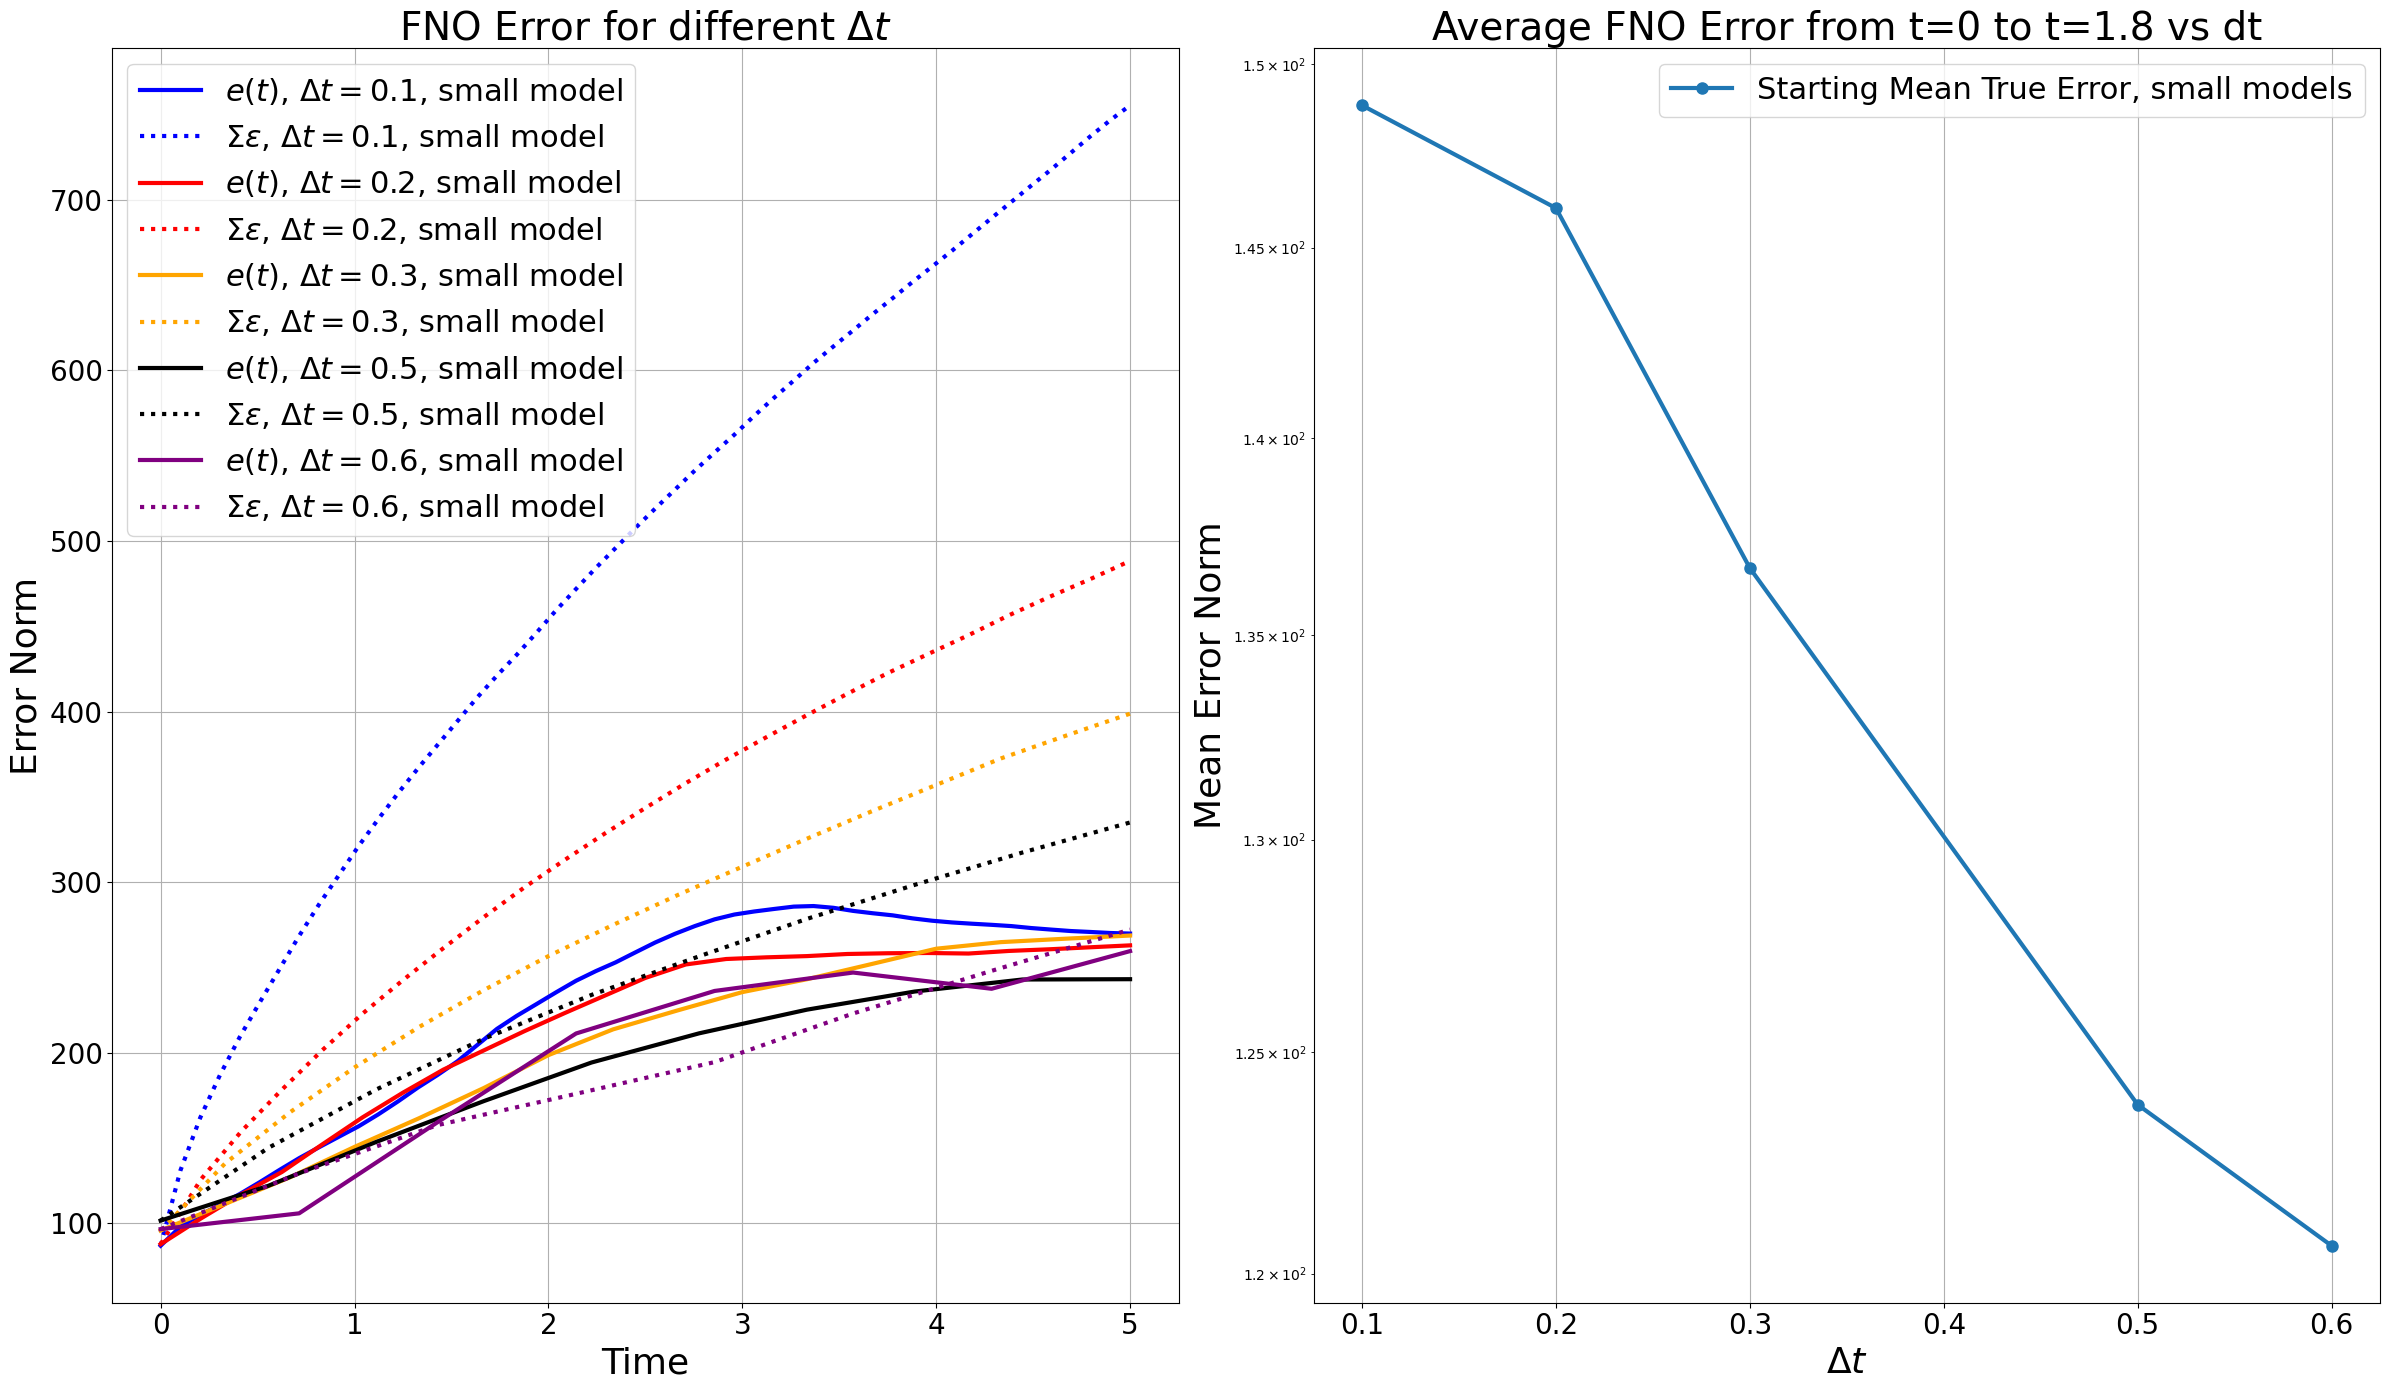

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(24, 14))
trange = 500
trange2 = 180
t_final = trange * 1e-2
print(t_final, trange2*1e-2)

# Define dt values and corresponding variable mappings
# dt_values = [0.03, 0.04, 0.05, 0.06, 0.08, 0.1,  0.3]  # Added 0.03 if needed
# lead_values = [3, 4,  5, 6, 8, 10, 30]

dt_values = [0.1, 0.2,  0.3,  0.5, 0.6]
lead_values = [ 10, 20, 30,  50, 60]

pred_vars = {
    # 0.03: net_pred_multistep_dt0_03,
    # 0.04: net_pred_multistep_dt0_04,
    # 0.05: net_pred_multistep_dt0_05,
    # 0.06: net_pred_multistep_dt0_06,
    # 0.08: net_pred_multistep_dt0_08,
    0.1: net_pred_multistep_dt0_1_small,
    0.2: net_pred_multistep_dt0_2_small,
    # 0.25: net_pred_multistep_dt0_25_small,
    0.3: net_pred_multistep_dt0_3_small,
    # 0.4: net_pred_multistep_dt0_4_small,
    0.5: net_pred_multistep_dt0_5_small,
    0.6: net_pred_multistep_dt0_6_small
}


# pred_vars_big = {
#     # 0.03: net_pred_multistep_dt0_03,
#     # 0.04: net_pred_multistep_dt0_04,
#     # 0.05: net_pred_multistep_dt0_05,
#     # 0.06: net_pred_multistep_dt0_06,
#     # 0.08: net_pred_multistep_dt0_08,
#     0.1: net_pred_multistep_dt0_1_big,
#     0.2: net_pred_multistep_dt0_2_big,
#     0.25: net_pred_multistep_dt0_25_big,
#     0.3: net_pred_multistep_dt0_3_big
# }



truth_vars = {
    # 0.03: truth_states_dt0_03,
    # 0.04: truth_states_dt0_04,
    # 0.05: truth_states_dt0_05,
    # 0.06: truth_states_dt0_06,
    # 0.08: truth_states_dt0_08,
    0.1: truth_states_dt0_1_small,
    0.2: truth_states_dt0_2_small,
    # 0.25: truth_states_dt0_25_small,
    0.3: truth_states_dt0_3_small,
    # 0.4: truth_states_dt0_4_small,
    0.5: truth_states_dt0_5_small,
    0.6: truth_states_dt0_6_small
}



# truth_vars_big = {
#     # 0.03: truth_states_dt0_03,
#     # 0.04: truth_states_dt0_04,
#     # 0.05: truth_states_dt0_05,
#     # 0.06: truth_states_dt0_06,
#     # 0.08: truth_states_dt0_08,
#     0.1: truth_states_dt0_1_big,
#     0.2: truth_states_dt0_2_big,
#     0.25: truth_states_dt0_25_big,
#     0.3: truth_states_dt0_3_big
# }




eps_vars = {
    # 0.03: eps_sum_multistep_dt0_03,
    # 0.04: eps_sum_multistep_dt0_04,
    # 0.05: eps_sum_multistep_dt0_05,
    # 0.06: eps_sum_multistep_dt0_06,
    # 0.08: eps_sum_multistep_dt0_08,
    0.1: eps_sum_multistep_dt0_1_small,
    0.2: eps_sum_multistep_dt0_2_small,
    # 0.25: eps_sum_multistep_dt0_25_small,
    0.3: eps_sum_multistep_dt0_3_small,
    # 0.4: eps_sum_multistep_dt0_4_small,
    0.5: eps_sum_multistep_dt0_5_small,
    0.6: eps_sum_multistep_dt0_6_small

}

# eps_vars_big = {
#     # 0.03: eps_sum_multistep_dt0_03,
#     # 0.04: eps_sum_multistep_dt0_04,
#     # 0.05: eps_sum_multistep_dt0_05,
#     # 0.06: eps_sum_multistep_dt0_06,
#     # 0.08: eps_sum_multistep_dt0_08,
#     0.1: eps_sum_multistep_dt0_1_big,
#     0.2: eps_sum_multistep_dt0_2_big,
#     0.25: eps_sum_multistep_dt0_25_big,
#     0.3: eps_sum_multistep_dt0_3_big
# }


colors = {
    # 0.03: 'purple',
    # 0.04: 'cyan',
    # 0.05: 'green',
    # 0.06: 'black',
    # 0.08: 'green',
    0.1: 'blue',
    0.2: 'red',
    # 0.25: 'green',
    0.3: 'orange',
    # 0.4: 'green',
    0.5: 'black',
    0.6: 'purple',

}


# colors_big = {
#     # 0.03: 'purple',
#     # 0.04: 'cyan',
#     # 0.05: 'green',
#     # 0.06: 'black',
#     # 0.08: 'green',
#     0.1: 'black',
#     0.2: 'cyan',
#     0.25: 'purple',
#     0.3: 'yellow'
# }

count = 0
# First subplot: Error curves over time
for dt in dt_values:
    # print(dt)
    lead = lead_values[count]  # convert dt to step stride

    # Get prediction and truth for this dt
    pred = pred_vars[dt]
    truth = truth_vars[dt]
    trange_temp = int(trange/lead)

    # Compute spatial norm, mean over ICs
    res_norm = np.linalg.norm(
        (pred[:, :trange_temp] - truth[:, :trange_temp].detach().cpu().numpy()),
        axis=(3, 4)
    ).mean(axis=0)  # mean over ICs
    
    axs[0].plot(np.linspace(0, t_final, res_norm.shape[0]),
                res_norm,
                color=colors[dt],
                label=r'$e(t)$, $\Delta t='+ str(dt)+'$, small model',
                linewidth=3)


    eps_sum = eps_vars[dt]
    
    eps_norm = np.linalg.norm(
        (eps_sum[:, :trange_temp]),
        axis=(3, 4)
    ).mean(axis=0)  # mean over ICs

    
    axs[0].plot(np.linspace(0, t_final, eps_norm.shape[0]),
                eps_norm,
                ':',
                color=colors[dt],
                label=r'$\Sigma\epsilon$, $\Delta t='+ str(dt)+'$, small model',
                linewidth=3)
    
    count += 1

# count = 0
# # First subplot: Error curves over time
# for dt in dt_values:
#     # print(dt)
#     lead = lead_values[count]  # convert dt to step stride

#     # Get prediction and truth for this dt
#     pred = pred_vars_big[dt]
#     truth = truth_vars_big[dt]
#     trange_temp = int(trange/lead)

#     # Compute spatial norm, mean over ICs
#     res_norm = np.linalg.norm(
#         (pred[:, :trange_temp] - truth[:, :trange_temp].detach().cpu().numpy()),
#         axis=(3, 4)
#     ).mean(axis=0)  # mean over ICs
    
#     axs[0].plot(np.linspace(0, t_final, res_norm.shape[0]),
#                 res_norm,
#                 color=colors_big[dt],
#                 label=f'True error, dt={dt}, large model',
#                 linewidth=3)
#     count += 1


axs[0].set_xlabel('Time', fontsize=6+20)
axs[0].set_ylabel('Error Norm', fontsize=6+20)
axs[0].set_title(r'FNO Error for different $\Delta t$ ', fontsize=6+22)
axs[0].legend(fontsize=6+16)
axs[0].grid(True)
axs[0].tick_params(axis='both', labelsize=20)

# Second subplot: Final error vs dt
final_errors = []
count = 0
for dt in dt_values:
    lead = lead_values[count]

    pred = pred_vars[dt]
    truth = truth_vars[dt]
    
    trange_temp = int(trange2/lead) 
    # trange_temp = int(0.5/lead)
    print(lead, trange_temp)
    # print(pred.shape, truth.shape)

    res_norm = np.linalg.norm(
        (pred[:, 0:trange_temp] - truth[:, 0:trange_temp].detach().cpu().numpy()),
        axis=(3, 4)
    )
    print(res_norm.shape)
    res_norm = res_norm.mean(axis=1).mean(axis=0)  # mean over ICs

    final_errors.append(res_norm)
    count += 1

# # Second subplot: Final error vs dt
# final_errors_big = []
# count = 0
# for dt in dt_values:
#     lead = lead_values[count]

#     pred = pred_vars_big[dt]
#     truth = truth_vars_big[dt]
    
#     trange_temp = int(trange2/lead) 
#     # trange_temp = int(0.5/lead)
#     print(lead, trange_temp)
#     # print(pred.shape, truth.shape)

#     res_norm = np.linalg.norm(
#         (pred[:, 0:trange_temp] - truth[:, 0:trange_temp].detach().cpu().numpy()),
#         axis=(3, 4)
#     )
#     print(res_norm.shape)
#     res_norm = res_norm.mean(axis=1).mean(axis=0)  # mean over ICs

#     final_errors_big.append(res_norm)
#     count += 1
    

axs[1].plot(dt_values, final_errors, 'o-', label='Starting Mean True Error, small models',
            linewidth=3, markersize=8)

# axs[1].plot(dt_values, final_errors_big, 'o-', label='Starting Mean True Error, large models',
#             linewidth=3, markersize=8)

axs[1].set_xlabel(r'$\Delta t$', fontsize=6+20)
axs[1].set_ylabel('Mean Error Norm', fontsize=6+20)
axs[1].set_title('Average FNO Error from t=0 to t=1.8 vs dt', fontsize=6+22)
axs[1].legend(fontsize=6+16)
axs[1].grid(True)
axs[1].tick_params(axis='both', labelsize=16)
axs[1].semilogy()
axs[1].tick_params(axis='both', labelsize=20)

plt.tight_layout()
plt.show()

(99, 1)

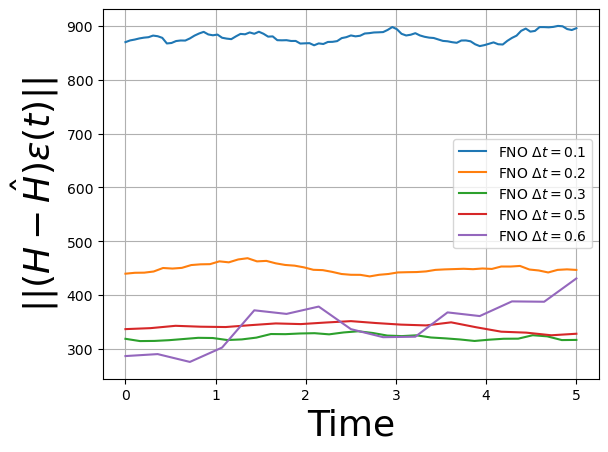

In [42]:

t_diff_dt0_1 = (net_pred_truth_multistep_dt0_1_small[:,1:] - truth_states_dt0_1_small[:,1:].cpu().numpy())/0.1
plt.plot(np.linspace(0, t_final, t_diff_dt0_1.shape[1]), np.linalg.norm(t_diff_dt0_1, axis=(3,4)).mean(0),label=r'FNO $\Delta t=0.1$')

t_diff_dt0_2 = (net_pred_truth_multistep_dt0_2_small[:,1:] - truth_states_dt0_2_small[:,1:].cpu().numpy())/0.2
plt.plot(np.linspace(0, t_final, t_diff_dt0_2.shape[1]), np.linalg.norm(t_diff_dt0_2, axis=(3,4)).mean(0),label=r'FNO $\Delta t=0.2$')

t_diff_dt0_3 = (net_pred_truth_multistep_dt0_3_small[:,1:] - truth_states_dt0_3_small[:,1:].cpu().numpy())/0.3
plt.plot(np.linspace(0, t_final, t_diff_dt0_3.shape[1]), np.linalg.norm(t_diff_dt0_3, axis=(3,4)).mean(0),label=r'FNO $\Delta t=0.3$')

# t_diff_dt0_4 = (net_pred_truth_multistep_dt0_4_small[:,1:] - truth_states_dt0_4_small[:,1:].cpu().numpy())/0.3
# plt.plot(np.linspace(0, t_final, t_diff_dt0_4.shape[1]), np.linalg.norm(t_diff_dt0_4, axis=(3,4)).mean(0),label=r'FNO $\Delta t=0.4$')

t_diff_dt0_5 = (net_pred_truth_multistep_dt0_5_small[:,1:] - truth_states_dt0_5_small[:,1:].cpu().numpy())/0.3
plt.plot(np.linspace(0, t_final, t_diff_dt0_5.shape[1]), np.linalg.norm(t_diff_dt0_5, axis=(3,4)).mean(0),label=r'FNO $\Delta t=0.5$')

t_diff_dt0_6 = (net_pred_truth_multistep_dt0_6_small[:,1:] - truth_states_dt0_6_small[:,1:].cpu().numpy())/0.3
plt.plot(np.linspace(0, t_final, t_diff_dt0_6.shape[1]), np.linalg.norm(t_diff_dt0_6, axis=(3,4)).mean(0),label=r'FNO $\Delta t=0.6$')



plt.xlabel('Time', fontsize=6+20)
plt.ylabel(r'$||(H - \hat{H})\epsilon(t)||$', fontsize=6+20)
plt.legend()
plt.grid(True)
# plt.tick_params(axis='both', labelsize=20)

10
15


KeyError: 0.15

Error in callback <function _draw_all_if_interactive at 0x7f7e97eeeb60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

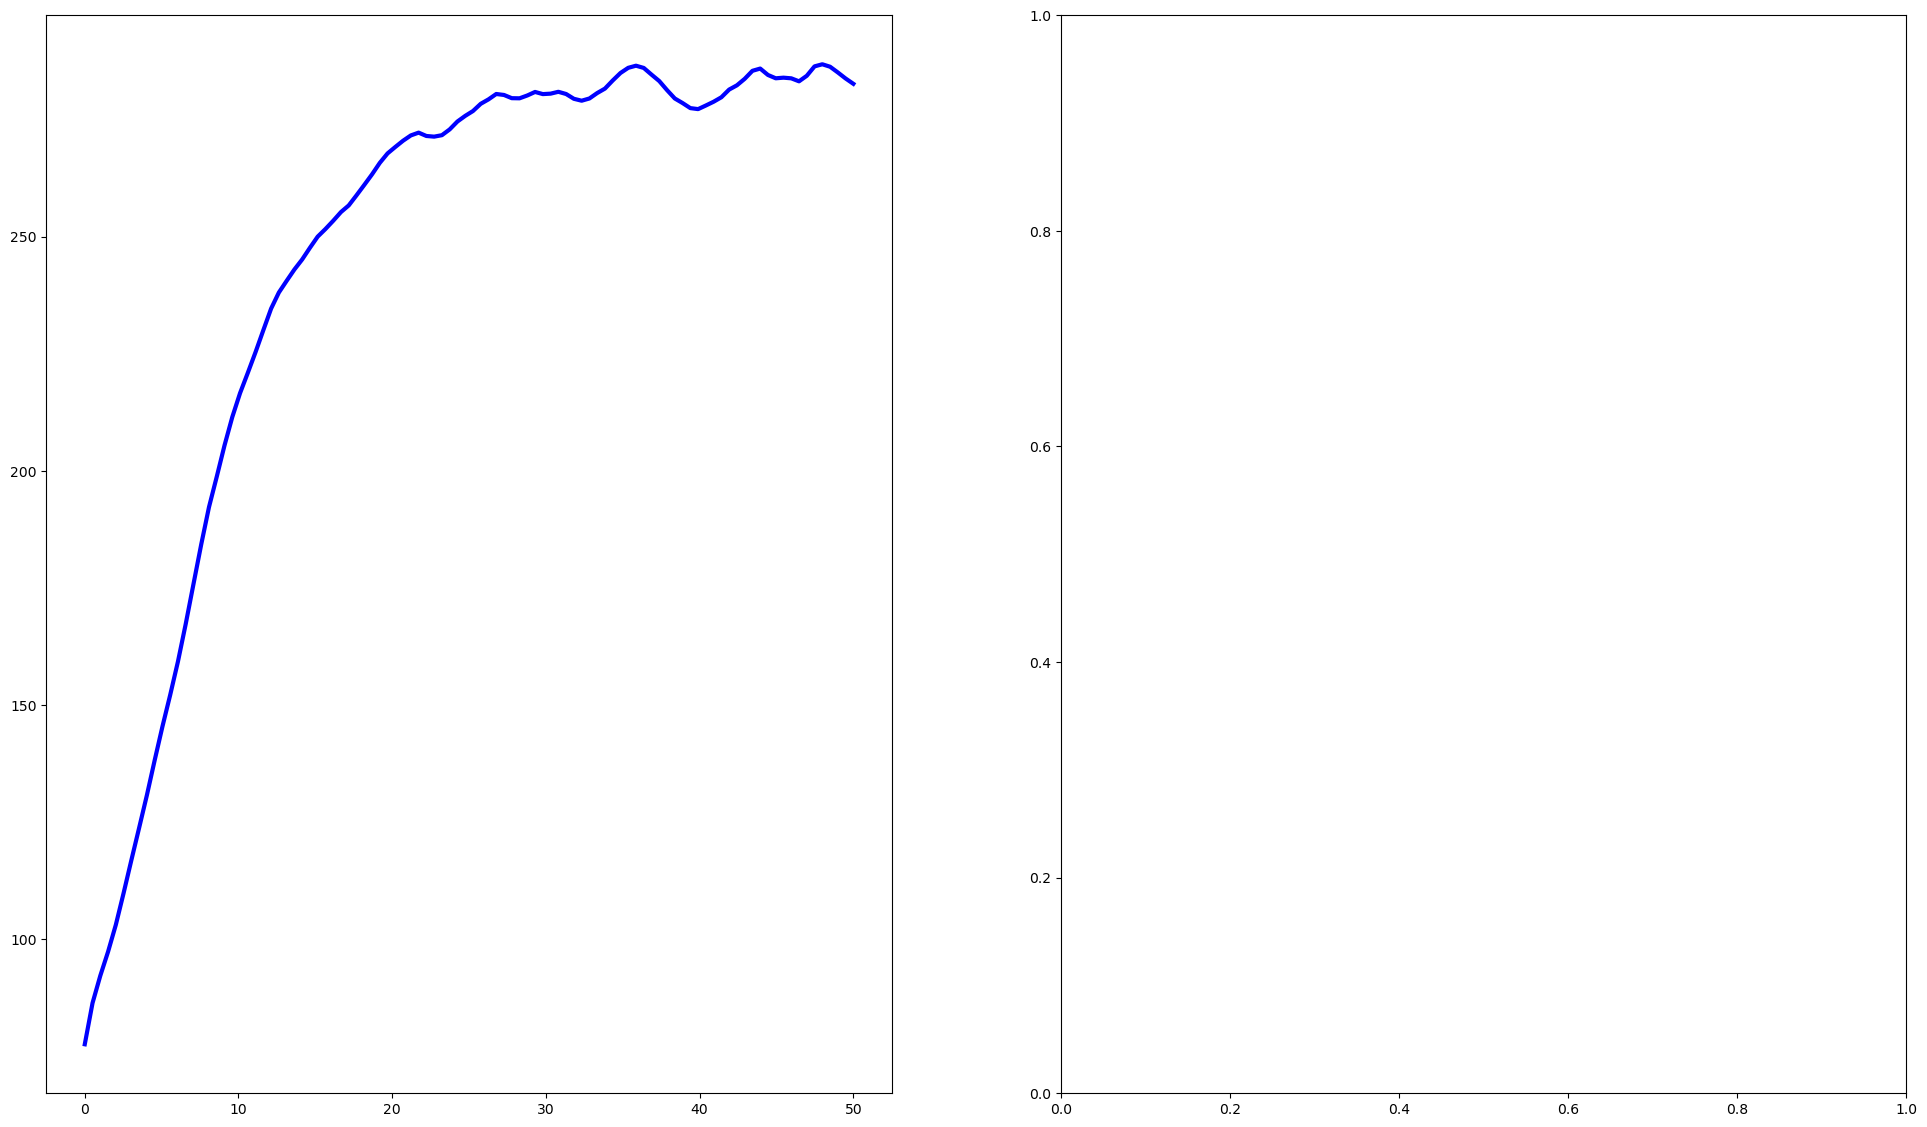

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(24, 14))
dt_values = [ 0.1, 0.15, 0.3]  # Added 0
for dt in dt_values:
    # print(dt)
    lead = int((1 / 1e-2) * dt)  # convert dt to step stride
    print(lead)
    # Get prediction and truth for this dt
    pred = pred_vars[dt]
    truth = truth_vars[dt]
    trange_temp = int(trange/lead)

    # Compute spatial norm, mean over ICs
    res_norm = np.linalg.norm(
        (pred[:, :] - truth[:, :].detach().cpu().numpy()),
        axis=(3, 4)
    ).mean(axis=0)  # mean over ICs
    
    axs[0].plot(np.linspace(0, t_final*lead, res_norm.shape[0]),
                res_norm,
                color=colors[dt],
                label=f'True error, dt={dt}',
                linewidth=3)
plt.show()

In [88]:
400*0.05

20.0